In [1]:
from metalib.utils import load_multiple_hist_data, load_hist_data

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [191]:
assets = ['EURUSD']

In [192]:
ohlc = pd.concat([load_hist_data(assets[0], 2020),
                 load_hist_data(assets[0], 2021),
                 load_hist_data(assets[0], 2022), 
                 load_hist_data(assets[0], 2023)]
                )
# ohlc = pd.concat([df for k,df in ohlc.items()], axis=1)
ohlc.index = pd.DatetimeIndex(ohlc.index, tz='UTC')
ohlc = ohlc.tz_convert(tz='US/Eastern')

C:\Users\Hermes\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.

C:\Users\Hermes\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.

C:\Users\Hermes\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.

C:\Users\Hermes\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning

In [194]:
ohlc_daily = ohlc.resample('1D').agg({'open': 'first', 
                         'high': 'max', 
                         'low': 'min', 
                         'close': 'last',
                         
                    })

In [163]:
ohlc_daily

,open,high,low,close
time,,,,
2020-01-01 00:00:00-05:00,0.74398,0.74781,0.74330,0.74682
2020-01-02 00:00:00-05:00,0.74682,0.74977,0.74566,0.74970
2020-01-03 00:00:00-05:00,0.74970,0.75038,0.74681,0.74747
2020-01-04 00:00:00-05:00,NaN,NaN,NaN,NaN
2020-01-05 00:00:00-05:00,0.74681,0.74859,0.74651,0.74719
...,...,...,...,...
2023-12-25 00:00:00-05:00,0.64396,0.64726,0.64390,0.64687
2023-12-26 00:00:00-05:00,0.64688,0.64793,0.64490,0.64521
2023-12-27 00:00:00-05:00,0.64521,0.64662,0.63104,0.63216


In [169]:
# Function to find the open of the second Monday of the month
def get_second_monday_open_ffill(ohlc_df, index_to_refill):
    """
    Returns a Pandas Series containing the 'open' prices of the second Monday of each month,
    forward-filled to match the original DataFrame's index.

    Parameters:
        ohlc_df (pd.DataFrame): Daily OHLC DataFrame with a datetime index and an 'open' column.

    Returns:
        pd.Series: Series with the same index as ohlc_df, containing forward-filled second Monday 'open' prices.
    """
    # Ensure the index is a datetime index
    if not isinstance(ohlc_df.index, pd.DatetimeIndex):
        ohlc_df.index = pd.to_datetime(ohlc_df.index)
    
    # Extract Mondays
    mondays = ohlc_df[ohlc_df.index.weekday == 0]  # 0 represents Monday

    # Group by year and month to find the second Monday
    second_mondays = mondays.groupby([mondays.index.year, mondays.index.month]).nth(1)  # nth(1) is the second Monday

    # Create a Series for second Monday opens
    second_monday_series = second_mondays['open']

    # Reindex to match the original DataFrame and forward-fill missing values
    second_monday_ffill = second_monday_series.reindex(index_to_refill, method='ffill')

    return second_monday_ffill

def get_first_monday_of_april_open_ffill(ohlc_df, index_to_refill):
    """
    Returns a Pandas Series containing the 'open' prices of the first Monday
    in April for each year, forward-filled to match the given index.

    Parameters:
        ohlc_df (pd.DataFrame): A daily (or intraday) DataFrame with a DateTime index and an 'open' column.
        index_to_refill (pd.Index): Index to which the returned Series will be reindexed and then forward-filled.

    Returns:
        pd.Series: A Series (same index as index_to_refill) with forward-filled
                   first Monday of April 'open' prices.
    """
    import pandas as pd
    
    # Ensure the index is a datetime index
    if not isinstance(ohlc_df.index, pd.DatetimeIndex):
        ohlc_df.index = pd.to_datetime(ohlc_df.index)
    
    # Filter for Mondays in April
    april_mondays = ohlc_df[
        (ohlc_df.index.month == 4) & (ohlc_df.index.weekday == 0)
    ]
    
    # Group by year to find the first Monday in April for each year
    first_mondays_april = april_mondays.groupby(april_mondays.index.year).nth(0)
    
    # Extract the 'open' column
    first_april_open = first_mondays_april['open']
    
    # Reindex to match the target index, then forward-fill
    first_april_open_ffill = first_april_open.reindex(index_to_refill, method='ffill')
    
    return first_april_open_ffill


def get_last_monday_6pm_open_ffill(ohlc_df, index_to_refill):
    """
    Returns a Pandas Series containing the 'open' prices of the last Monday at 6 PM
    for each month, forward-filled to match the given index.

    Parameters:
        ohlc_df (pd.DataFrame): An intraday DataFrame with a DateTime index (including hour)
                                and an 'open' column.
        index_to_refill (pd.Index): Index to which the returned Series will be reindexed and then forward-filled.

    Returns:
        pd.Series: A Series (same index as index_to_refill) with the forward-filled
                   last Monday 6 PM 'open' prices in each month.
    """
    
    # Ensure the index is a datetime index
    if not isinstance(ohlc_df.index, pd.DatetimeIndex):
        ohlc_df.index = pd.to_datetime(ohlc_df.index)
    
    # Filter to Mondays at 6 PM (18:00)
    monday_6pm = ohlc_df[
        (ohlc_df.index.weekday == 0) & (ohlc_df.index.hour == 18) & (ohlc_df.index.minute == 0)
    ]
    
    # Group by year-month and select the last entry for each group
    last_monday_6pm = monday_6pm.groupby([
        monday_6pm.index.year, 
        monday_6pm.index.month
    ]).tail(1)
    
    # Extract the 'open' column
    last_monday_6pm_open = last_monday_6pm['open']
    
    # Reindex to match the target index, then forward-fill
    last_monday_6pm_open_ffill = last_monday_6pm_open.reindex(index_to_refill, method='ffill')
    
    return last_monday_6pm_open_ffill


In [195]:
true_open_monthly = get_second_monday_open_ffill(ohlc_daily, ohlc.index)
true_open_yearly = get_first_monday_of_april_open_ffill(ohlc_daily, ohlc.index)
true_open_weekly = get_last_monday_6pm_open_ffill(ohlc, ohlc.index)

In [175]:
true_open_monthly

time
2020-01-01 12:00:00-05:00        NaN
2020-01-01 12:01:00-05:00        NaN
2020-01-01 12:02:00-05:00        NaN
2020-01-01 12:03:00-05:00        NaN
2020-01-01 12:04:00-05:00        NaN
                              ...   
2023-12-29 11:54:00-05:00    0.64658
2023-12-29 11:55:00-05:00    0.64658
2023-12-29 11:56:00-05:00    0.64658
2023-12-29 11:57:00-05:00    0.64658
2023-12-29 11:58:00-05:00    0.64658
Name: open, Length: 1431682, dtype: float64

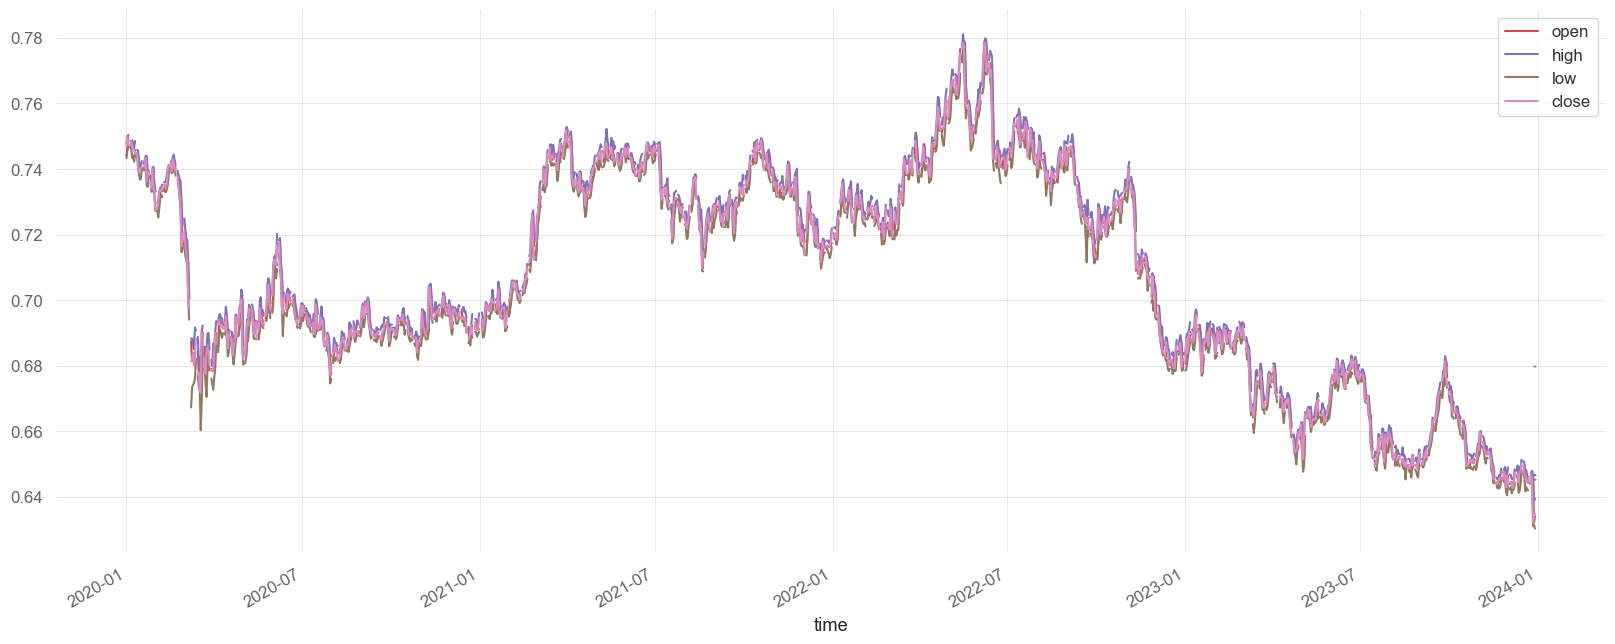

In [176]:
fig, ax = plt.subplots()

true_open_monthly.tail(2000).plot(figsize=(20, 8), ax=ax)
true_open_yearly.tail(2000).plot(figsize=(20, 8), ax=ax)
true_open_weekly.tail(2000).plot(figsize=(20, 8), ax=ax)

ohlc_daily.tail(2000).plot(figsize=(20, 8), ax=ax)

plt.show()

In [197]:
trend_weekly = ohlc.close > ohlc.open.rolling(24*60*5*5).median()
trend_daily = ohlc.close > ohlc.open.rolling(24*60*5).median()
trend_hourly = ohlc.close > ohlc.open.rolling(60*5).median()
trend_entry = ohlc.close > ohlc.open.rolling(15).median()


# Calculate the difference from the rolling median of 'open' prices

# Weekly Trend (5 weeks of trading days, assuming 24 hours * 60 mins * 5 days * 5 weeks)
trend_weekly_diff = ohlc['close'] - ohlc['open'].rolling(window=24*60*5*5).median()

# Daily Trend (5 trading days, assuming 24 hours * 60 mins * 5 days)
trend_daily_diff = ohlc['close'] - ohlc['open'].rolling(window=24*60*5).median()

# Hourly Trend (5 hours, assuming 60 mins * 5 hours)
trend_hourly_diff = ohlc['close'] - ohlc['open'].rolling(window=60*5).median()

# Entry Trend (15-minute rolling window)
trend_entry_diff = ohlc['close'] - ohlc['open'].rolling(window=15).median()

# Difference from the 'true open' reference
above_true_open_monthly_diff = ohlc['close'] - true_open_monthly
above_true_open_yearly_diff = ohlc['close'] - true_open_yearly
# Difference from the 'true open' reference
above_true_open_weekly_diff = ohlc['close'] - true_open_weekly

In [ ]:
def support_resistance_levels(
        data: pd.DataFrame, lookback: int, 
        first_w: float = 0.01, atr_mult:float=3.0, prom_thresh:float =0.25
):

    # Get log average true range, 
    atr = ta.atr(np.log(data['high']), np.log(data['low']), np.log(data['close']), lookback)

    all_levels = [None] * len(data)
    for i in range(lookback, len(data)):
        i_start  = i - lookback
        vals = np.log(data.iloc[i_start+1: i+1]['close'].to_numpy())
        levels, peaks, props, price_range, pdf, weights= find_levels(vals, atr.iloc[i], first_w, atr_mult, prom_thresh)
        all_levels[i] = levels
        
    return all_levels

In [198]:
# indicators = pd.concat([above_true_open,
#                         trend_weekly,
#                         trend_daily,
#                         trend_hourly,
#                         trend_entry
#                         ], 
#                        axis=1).astype(int)
# indicators.columns = ["above_true_open", "bullish_weekly", "bullish_daily", "bullish_hourly", "bullish_entry"]
# Concatenate the difference indicators instead of boolean values

indicators = pd.concat([
    above_true_open_monthly_diff,
    above_true_open_yearly_diff,
    above_true_open_weekly_diff,# Difference from the true open
    trend_weekly_diff,      # Weekly trend difference
    trend_daily_diff,       # Daily trend difference
    trend_hourly_diff,      # Hourly trend difference
    trend_entry_diff        # Entry trend difference
], axis=1)

# Rename the columns to keep the original naming convention
indicators.columns = ["above_true_open_monthly_diff", "above_true_open_yearly_diff", "above_true_open_weekly_diff", "bullish_weekly", "bullish_daily", "bullish_hourly", "bullish_entry"]


In [199]:
import numba as nb

@nb.njit()
def log_return_nb(x):
    return np.log(x[-1]/x[0])

next_returns = ohlc.close.rolling(48*60).apply(log_return_nb, engine='numba', raw=True).shift(48*60)

In [200]:
up_next_returns = next_returns > 0

In [201]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
import statsmodels.api as sm


X_train, X_test, y_train, y_test = train_test_split(indicators, up_next_returns, test_size=0.2, shuffle=False)

# OLS

In [255]:
# Add a constant to the model (for the intercept)
X_train = sm.add_constant(X_train)

# Fit the OLS regression model
model = sm.OLS(y_train, X_train).fit()

# Predictions
y_pred = model.predict(X_train)

# Performance Metrics
r_squared = model.rsquared
adj_r_squared = model.rsquared_adj
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)

metrics = {
    'R-squared': r_squared,
    'Adjusted R-squared': adj_r_squared,
    'MSE': mse,
    'RMSE': rmse
}

# Display the regression summary
print(model.summary())

MissingDataError: exog contains inf or nans

# Logit

In [173]:
# Add a constant to the model (for the intercept)
X_train = sm.add_constant(X_train)

# Fit the OLS regression model
model = sm.Logit(y_train, X_train).fit()

# Predictions
y_pred = model.predict(X_train)

# Performance Metrics
r_squared = model.prsquared
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)

metrics = {
    'R-squared': r_squared,
    'MSE': mse,
    'RMSE': rmse
}

# Display the regression summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.415590
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  close   No. Observations:              1149872
Model:                          Logit   Df Residuals:                  1149866
Method:                           MLE   Df Model:                            5
Date:                Sat, 01 Feb 2025   Pseudo R-squ.:                  0.4004
Time:                        15:57:33   Log-Likelihood:            -4.7788e+05
converged:                       True   LL-Null:                   -7.9702e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.9572      0.005   -369.586      0.000      -1.968      -1.947
above_true_ope

# Catboost

In [183]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error, log_loss

def catboost_classification_with_metrics(X_train, y_train):
    """
    Fits a CatBoostClassifier, makes predictions, and computes performance metrics.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Binary target variable.

    Returns:
        model (CatBoostClassifier): Trained CatBoost model.
        metrics (dict): Dictionary containing Pseudo R-squared, MSE, and RMSE.
    """
    # Initialize CatBoost Classifier
    model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=4,
        verbose=0,  # Suppress output
        loss_function='Logloss'  # Equivalent to logistic regression
    )

    # Fit the model
    model.fit(X_train, y_train)

    # Predictions (probabilities)
    y_pred_proba = model.predict_proba(X_train)[:, 1]  # Probability of class 1

    # Performance Metrics
    # 1. Pseudo R-squared (similar to Logit model's prsquared)
    ll_full = -log_loss(y_train, y_pred_proba, normalize=False)
    ll_null = -log_loss(y_train, np.full_like(y_train, y_train.mean()), normalize=False)
    pseudo_r_squared = 1 - (ll_full / ll_null)

    # 2. Mean Squared Error (MSE)
    mse = mean_squared_error(y_train, y_pred_proba)

    # 3. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Metrics dictionary
    metrics = {
        'Pseudo R-squared': pseudo_r_squared,
        'MSE': mse,
        'RMSE': rmse
    }

    # Display Model Summary (feature importance)
    print("Feature Importance:")
    feature_importance = pd.Series(model.get_feature_importance(), index=X_train.columns)
    print(feature_importance.sort_values(ascending=False))

    return model, metrics


In [202]:
model, performance_metrics = catboost_classification_with_metrics(X_train, y_train)

Feature Importance:
bullish_daily                   23.767874
above_true_open_monthly_diff    20.698193
bullish_weekly                  18.537253
above_true_open_yearly_diff     17.842668
above_true_open_weekly_diff     15.939113
bullish_hourly                   3.214898
bullish_entry                    0.000000
dtype: float64


In [18]:
X_test

,above_true_open,bullish_weekly,bullish_daily,bullish_hourly,bullish_entry
time,,,,,
2023-02-02 23:58:00-05:00,0.01470,0.01036,0.01050,-0.000125,-0.00025
2023-02-02 23:59:00-05:00,0.01484,0.01050,0.01064,0.000015,-0.00011
2023-02-03 00:00:00-05:00,0.01457,0.01023,0.01037,-0.000270,-0.00037
2023-02-03 00:01:00-05:00,0.01476,0.01042,0.01056,-0.000080,-0.00018
2023-02-03 00:02:00-05:00,0.01472,0.01038,0.01052,-0.000120,-0.00022
...,...,...,...,...,...
2023-12-29 11:54:00-05:00,0.00917,0.00409,-0.00090,0.000015,0.00021
2023-12-29 11:55:00-05:00,0.00934,0.00426,-0.00073,0.000185,0.00033
2023-12-29 11:56:00-05:00,0.00920,0.00412,-0.00087,0.000045,0.00019


In [22]:
y_pred = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

In [27]:
conf_matrix = confusion_matrix(y_test, y_pred > 0.5)

In [28]:
pd.DataFrame( conf_matrix ).style.background_gradient(axis=None)

,0,1
0,90411,56986
1,45206,94872


<Axes: >

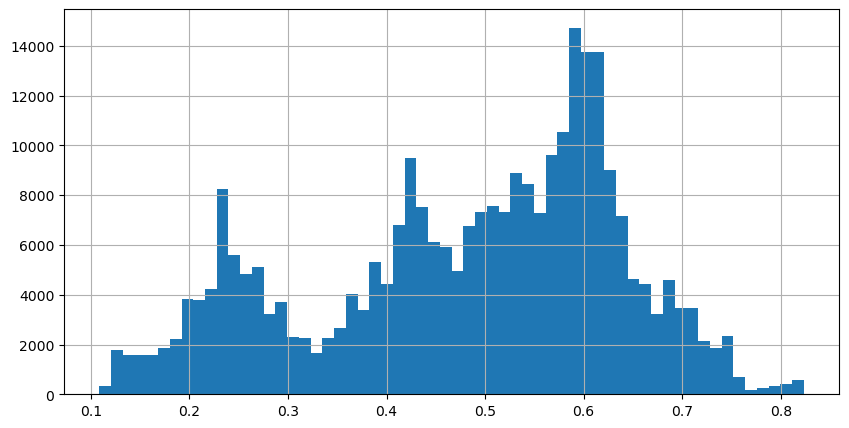

In [29]:
y_pred.hist(bins=60, figsize=(10, 5))

In [33]:
import vectorbt as vbt

In [73]:
def generate_signals(y_pred, threshold=0.2):
    """
    Generates long and short signals with corresponding exits 48 hours after the entry.

    Parameters:
        y_pred (pd.Series): Series representing probabilities of bullish signals (0 to 1).

    Returns:
        pd.DataFrame: DataFrame containing long_signals, long_exits, short_signals, short_exits.
    """
    # Entry signals
    long_signals = y_pred > threshold
    short_signals = y_pred < -threshold

    # Exit signals (48 hours after entry)
    # Assuming y_pred has datetime index with hourly frequency
    long_exits = long_signals.shift(48*60, fill_value=False)
    short_exits = short_signals.shift(48*60, fill_value=False)

#     long_exits = y_pred.vbt.crossed_below(0.5)
#     short_exits = y_pred.vbt.crossed_above(0.5)
    
    # Long exists (holding the long position after the signal)
    long_exists = long_signals.cumsum() - long_exits.cumsum() > 0

    # Create DataFrame for better visualization
    signals_df = pd.DataFrame({
        'long_signals': long_signals.astype(bool),
        'long_exists': long_exists.astype(bool),
        'long_exits': long_exits.astype(bool),
        'short_signals': short_signals.astype(bool),
        'short_exits': short_exits.astype(bool)
    }, index=y_pred.index)

    return signals_df


In [207]:
y_pred = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

y_pred_mean = y_pred.rolling(60*3).mean()
y_pred_std = (y_pred-y_pred_mean).rolling(60*3).std()
y_pred_norm = (y_pred - y_pred_mean)/(y_pred_std)

signals = generate_signals(y_pred_norm, 1.5)

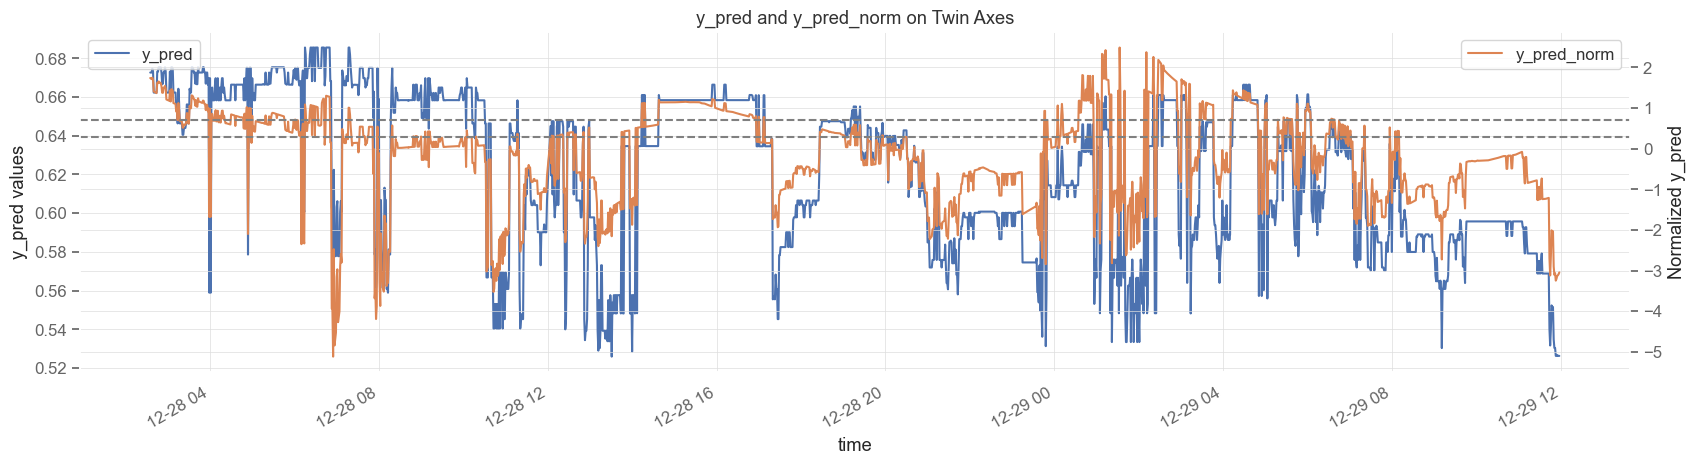

In [128]:
fig, ax1 = plt.subplots(figsize=(20,5))

# Plot the first time series on ax1
y_pred.tail(2000).plot(ax=ax1, label="y_pred", color="C0")
ax1.set_ylabel("y_pred values")  # Label for the left y-axis
ax1.legend(loc="upper left")

# Create the twin axis that shares the x-axis
ax2 = ax1.twinx()

# Plot the normalized values on the twin axis
y_pred_norm.tail(2000).plot(ax=ax2, label="y_pred_norm", color="C1")
ax2.set_ylabel("Normalized y_pred")  # Label for the right y-axis
ax2.legend(loc="upper right")

# Add the horizontal lines on the twin axis (because they correspond to y_pred_norm)
ax2.axhline(1 - 0.3, color="gray", linestyle="--")
ax2.axhline(0.3, color="gray", linestyle="--")

plt.title("y_pred and y_pred_norm on Twin Axes")
plt.show()

In [208]:
common = signals.index.intersection(ohlc.index)

portfolio = vbt.Portfolio.from_signals(
    close=ohlc.close.loc[common],  # Use actual price series here
    entries=signals['long_signals'].loc[common].astype(int),
    exits=signals['long_exits'].loc[common].astype(int),
    init_cash=1000000,
    size=1,
    short_entries=signals['short_signals'].loc[common].astype(int),
    short_exits=signals['short_exits'].loc[common].astype(int),
    freq="1m",
    accumulate=False,
)

In [209]:
portfolio.stats()

Start                         2023-02-03 03:20:00-05:00
End                           2023-12-29 11:58:00-05:00
Period                                199 days 15:08:00
Start Value                                   1000000.0
End Value                                 1000000.07495
Total Return [%]                               0.000007
Benchmark Return [%]                            0.97257
Max Gross Exposure [%]                         0.000113
Total Fees Paid                                     0.0
Max Drawdown [%]                               0.000003
Max Drawdown Duration                  39 days 08:13:00
Total Trades                                       3628
Total Closed Trades                                3627
Total Open Trades                                     1
Open Trade PnL                                  0.00018
Win Rate [%]                                  50.813344
Best Trade [%]                                 1.458685
Worst Trade [%]                               -1

In [75]:
(signals["long_signals"] & signals["long_exits"]).sum()

26

In [115]:
signals['long_signals'].loc[common].sum()

224806

In [157]:
portfolio.plot_position_pnl()

FigureWidget({
    'data': [{'customdata': array([[1.00000000e+00, 1.80000000e-04, 2.01893311e-04],
                                   [2.00000000e+00, 2.00000000e-05, 2.24371200e-05],
                                   [5.00000000e+00, 2.60000000e-04, 2.91626942e-04],
                                   ...,
                                   [1.40810000e+04, 9.00000000e-05, 1.03836170e-04],
                                   [1.40820000e+04, 4.00000000e-05, 4.61446172e-05],
                                   [1.40830000e+04, 1.60000000e-04, 1.84586987e-04]]),
              'hovertemplate': ('Position Id: %{customdata[0]}<' ... 'r>Return: %{customdata[2]:.2%}'),
              'marker': {'color': '#37B13F',
                         'line': {'color': 'rgb(38,123,44)', 'width': 1},
                         'opacity': array([0.75393674, 0.7504375 , 0.75568647, ..., 0.75202471, 0.75089978,
                                           0.75359928]),
                         'size': array([7.183

In [109]:
portfolio.plot_trades()


KeyboardInterrupt

